In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
from modules import at2df # Small custom wrapper functions for the Airtable library

In [3]:
# Output settings
SAVE = True
SAVEDIR = 'tmp'
kwargs_svg = {'format': 'svg', 'bbox_inches': 'tight', 'facecolor': 'white'}
kwargs_png = {'format': 'png', 'bbox_inches': 'tight', 'dpi': 300}

In [4]:
at = at2df.get_airtable()

In [5]:
df = at2df.get_table_as_df(at, 'Constitutional Model')

In [6]:
def plot_coded_column(col, label=''):
    """Plot frequency of unique list items for coded columns"""
    
    # Make sure all values in column are lists
    df[col] = df[col].apply(lambda d: d if isinstance(d, list) else [])
    
    # One-hot encode column of lists
    mlb = MultiLabelBinarizer(sparse_output=True)
    df_onehot = pd.DataFrame.sparse.from_spmatrix(
        mlb.fit_transform(df[col]),
        index=df.index,
        columns=mlb.classes_)
    
    # Get count for each unique item
    df_sum = pd.DataFrame(df_onehot.sum()).sort_values(0, axis=0, ascending=False).transpose()
    
    # Plot bar chart of unique list items
    plt.plot()
    sns.barplot(data=df_sum, orient='h')
    plt.ylabel(label)
    plt.xlabel('Frequency')
    
    fname = f"{SAVEDIR}/constitution_model_{label}"
    plt.savefig(f"{fname}.png", **kwargs_png)

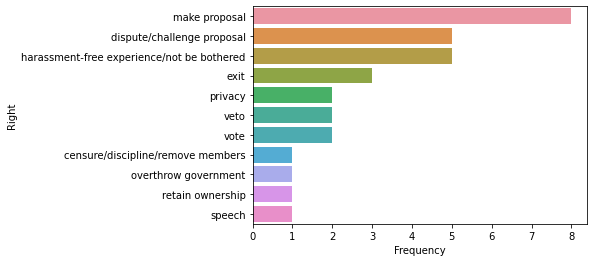

In [7]:
plot_coded_column('rights_code', label='Right')

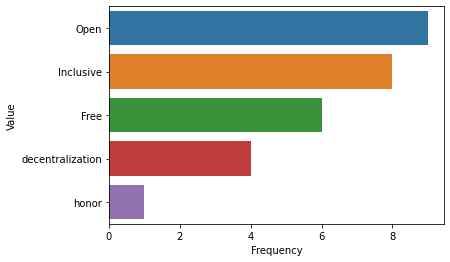

In [8]:
plot_coded_column('values_code', label='Value')

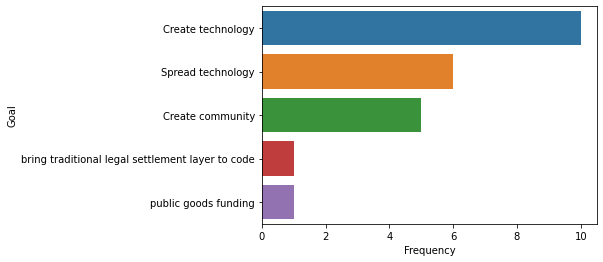

In [9]:
plot_coded_column('goals_code', label='Goal')